In [9]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [1]:
# Cell 1: Download & Load Steam Dataset via kagglehub
import os
import pandas as pd
import kagglehub

# 1) Download the latest version of the Kaggle dataset
data_path = kagglehub.dataset_download("antonkozyriev/game-recommendations-on-steam")
print("Dataset downloaded to:", data_path)

# 2) Unpack if it’s a zip (kagglehub may return an extract directory)
#    Adjust this if your environment auto-extracts
import zipfile
archive = os.path.join(data_path, "game-recommendations-on-steam.zip")
if os.path.exists(archive):
    with zipfile.ZipFile(archive, 'r') as z:
        z.extractall(data_path)
        print("Archive extracted")

# 3) Define file paths
games_file = os.path.join(data_path, "games.csv")
users_file = os.path.join(data_path, "users.csv")
recs_file  = os.path.join(data_path, "recommendations.csv")

# 4) Load the smaller CSVs directly
games = pd.read_csv(games_file)
users = pd.read_csv(users_file)
print("Games shape:", games.shape)
print("Users shape:", users.shape)

# 5) for recommendations.csv read in chunks or sample:
chunksize = 2_000_000
sample_frac = 0.01
recs_chunks = []
for chunk in pd.read_csv(recs_file, chunksize=chunksize):
    recs_chunks.append(chunk.sample(frac=sample_frac, random_state=42))
recs = pd.concat(recs_chunks, ignore_index=True)
print("Recommendations shape:", recs.shape)


100%|██████████| 660M/660M [00:07<00:00, 93.4MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/antonkozyriev/game-recommendations-on-steam/versions/28
Games shape: (50872, 13)
Users shape: (14306064, 3)
Sampled recommendations shape: (411548, 8)


In [2]:
games

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50867,2296380,I Expect You To Die 3: Cog in the Machine,2023-09-28,True,False,False,Very Positive,96,101,22.00,0.00,0.0,True
50868,1272080,PAYDAY 3,2023-09-21,True,False,False,Mostly Negative,38,29458,40.00,0.00,0.0,True
50869,1402110,Eternights,2023-09-11,True,False,False,Very Positive,89,1128,30.00,0.00,0.0,True
50870,2272250,Forgive Me Father 2,2023-10-19,True,False,False,Very Positive,95,82,17.00,0.00,0.0,True


In [3]:
users

,user_id,products,reviews
0,7360263,359,0
1,14020781,156,1
2,8762579,329,4
3,4820647,176,4
4,5167327,98,2
...,...,...,...
14306059,5047430,6,0
14306060,5048153,0,0
14306061,5059205,31,0
14306062,5074363,0,0


In [4]:
recs

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,1286830,0,0,2022-04-23,False,3.0,7142009,1828401
1,105600,0,0,2020-08-16,True,163.6,3420046,1200071
2,271590,0,0,2016-12-30,True,888.0,7769268,194849
3,306130,0,0,2020-05-17,True,161.5,152267,1629054
4,252490,0,0,2021-01-02,True,133.7,5786032,191144
...,...,...,...,...,...,...,...,...
411543,1046930,0,0,2019-06-29,True,63.0,5588220,40316606
411544,362960,0,0,2016-12-01,True,36.0,13898060,40938100
411545,1057090,0,0,2022-08-25,True,19.0,6253918,41017376
411546,1891700,0,0,2022-11-22,True,13.0,13550664,40372053


In [5]:
# Cell 2: Data Cleaning & Type Conversion
# Games
games['date_release'] = pd.to_datetime(games['date_release'])
games['discount'] = games['discount'].fillna(0)
games['price_final'] = pd.to_numeric(games['price_final'], errors='coerce').fillna(0)
games['user_reviews'] = pd.to_numeric(games['user_reviews'], errors='coerce').fillna(0)

# Users
users['reviews'] = pd.to_numeric(users['reviews'], errors='coerce').fillna(0)
users['products'] = pd.to_numeric(users['products'], errors='coerce').fillna(0)

# Recs
recs['date'] = pd.to_datetime(recs['date'])
recs['hours'] = pd.to_numeric(recs['hours'], errors='coerce').fillna(0)
recs['helpful'] = recs['helpful'].astype(int)
recs['funny']   = recs['funny'].astype(int)
recs['is_recommended'] = recs['is_recommended'].astype(bool)

# Drop duplicates if any
games.drop_duplicates('app_id', inplace=True)
users.drop_duplicates('user_id', inplace=True)
recs.drop_duplicates('review_id', inplace=True)

print("After cleaning:", games.shape, users.shape, recs.shape)


After cleaning: (50872, 13) (14306064, 3) (411548, 8)


<ipython-input-16-d77f8cc02317>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=games, x='rating',


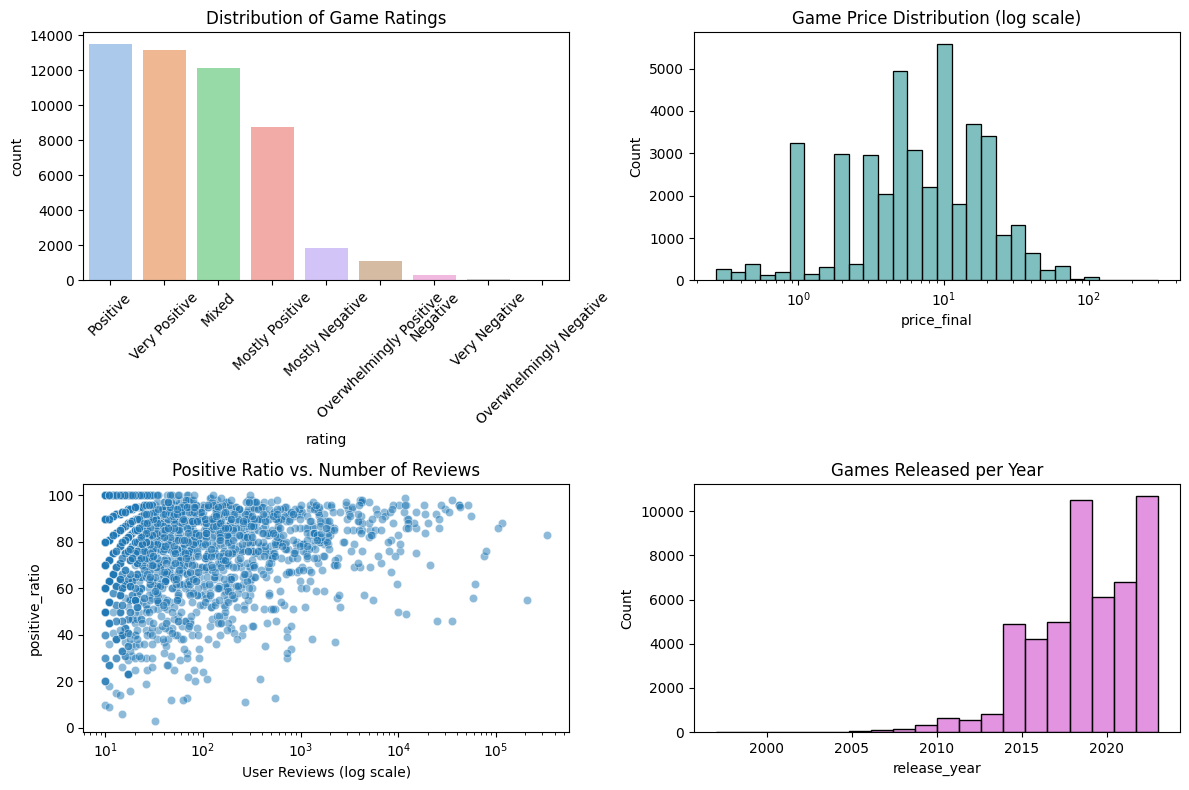

In [16]:
# === Cell 2a: EDA on games.csv ===

plt.figure(figsize=(12,8))

# 1) Rating distribution
plt.subplot(2,2,1)
sns.countplot(data=games, x='rating',
              order=games['rating'].value_counts().index,
              palette='pastel')
plt.title('Distribution of Game Ratings')
plt.xticks(rotation=45)

# 2) Price distribution (log scale)
plt.subplot(2,2,2)
sns.histplot(games['price_final'], bins=30, log_scale=True, kde=True, color='teal')
plt.title('Game Price Distribution (log scale)')

# 3) Positive ratio vs. user reviews
plt.subplot(2,2,3)
sns.scatterplot(x='user_reviews', y='positive_ratio',
                data=games.sample(2000, random_state=42),
                alpha=0.5)
plt.xscale('log')
plt.title('Positive Ratio vs. Number of Reviews')
plt.xlabel('User Reviews (log scale)')

# 4) Release year counts
games['release_year'] = games['date_release'].dt.year
plt.subplot(2,2,4)
sns.histplot(games['release_year'], bins=20, color='orchid')
plt.title('Games Released per Year')

plt.tight_layout()
plt.show()


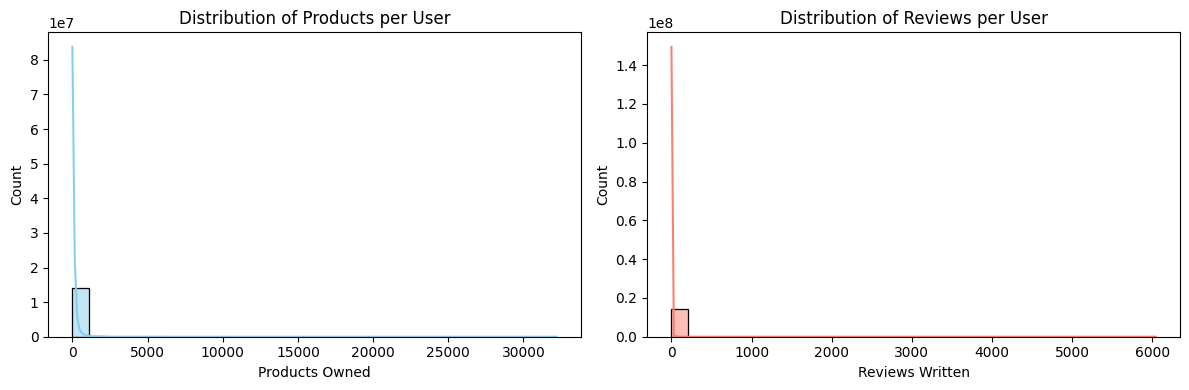

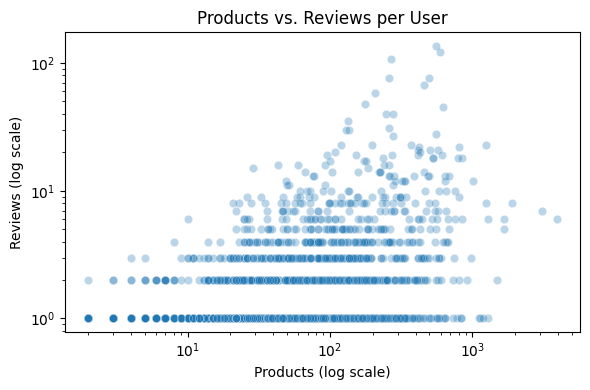

In [17]:
# === Cell 2b: EDA on users.csv ===
plt.figure(figsize=(12,4))

# 1) Number of products histogram
plt.subplot(1,2,1)
sns.histplot(users['products'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Products per User')
plt.xlabel('Products Owned')

# 2) Number of reviews histogram
plt.subplot(1,2,2)
sns.histplot(users['reviews'], bins=30, kde=True, color='salmon')
plt.title('Distribution of Reviews per User')
plt.xlabel('Reviews Written')

plt.tight_layout()
plt.show()

# 3) Scatter: products vs reviews
plt.figure(figsize=(6,4))
sns.scatterplot(x='products', y='reviews', data=users.sample(2000, random_state=42), alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.title('Products vs. Reviews per User')
plt.xlabel('Products (log scale)')
plt.ylabel('Reviews (log scale)')
plt.tight_layout()
plt.show()


In [6]:
# Cell 3: Merge Datasets
df = recs.merge(games, on='app_id', how='left') \
         .merge(users, on='user_id', how='left')

# Quick null check
print("Merged DF nulls:\n", df[['title','price_final','products']].isna().sum())


Merged DF nulls:
 title          0
price_final    0
products       0
dtype: int64


In [7]:
# Cell 4: Feature Engineering
# Rating numeric (map positive_ratio)
df['pos_ratio_num'] = df['positive_ratio'] / 100

# Release year
df['year_release'] = df['date_release'].dt.year

# Age at review
df['age_at_review'] = df['date'].dt.year - df['year_release']

# Platform count
df['platforms'] = df[['win','mac','linux']].sum(axis=1)

# Bin user_reviews
df['reviews_bin'] = pd.qcut(df['user_reviews'], 5, labels=False)

# Preview
display(df[['title','date','hours','is_recommended','price_final','pos_ratio_num','age_at_review','platforms']].head())


,title,date,hours,is_recommended,price_final,pos_ratio_num,age_at_review,platforms
0,STAR WARS™: The Old Republic™,2022-04-23,3.0,False,0.0,0.89,2,1
1,Terraria,2020-08-16,163.6,True,10.0,0.97,9,3
2,Grand Theft Auto V,2016-12-30,888.0,True,0.0,0.86,1,1
3,The Elder Scrolls® Online,2020-05-17,161.5,True,20.0,0.83,3,2
4,Rust,2021-01-02,133.7,True,40.0,0.87,3,2


<ipython-input-10-dbb459950635>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=games, order=games['rating'].value_counts().index, palette='pastel')
<ipython-input-10-dbb459950635>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_recommended', data=df, palette=['lightcoral','lightgreen'])


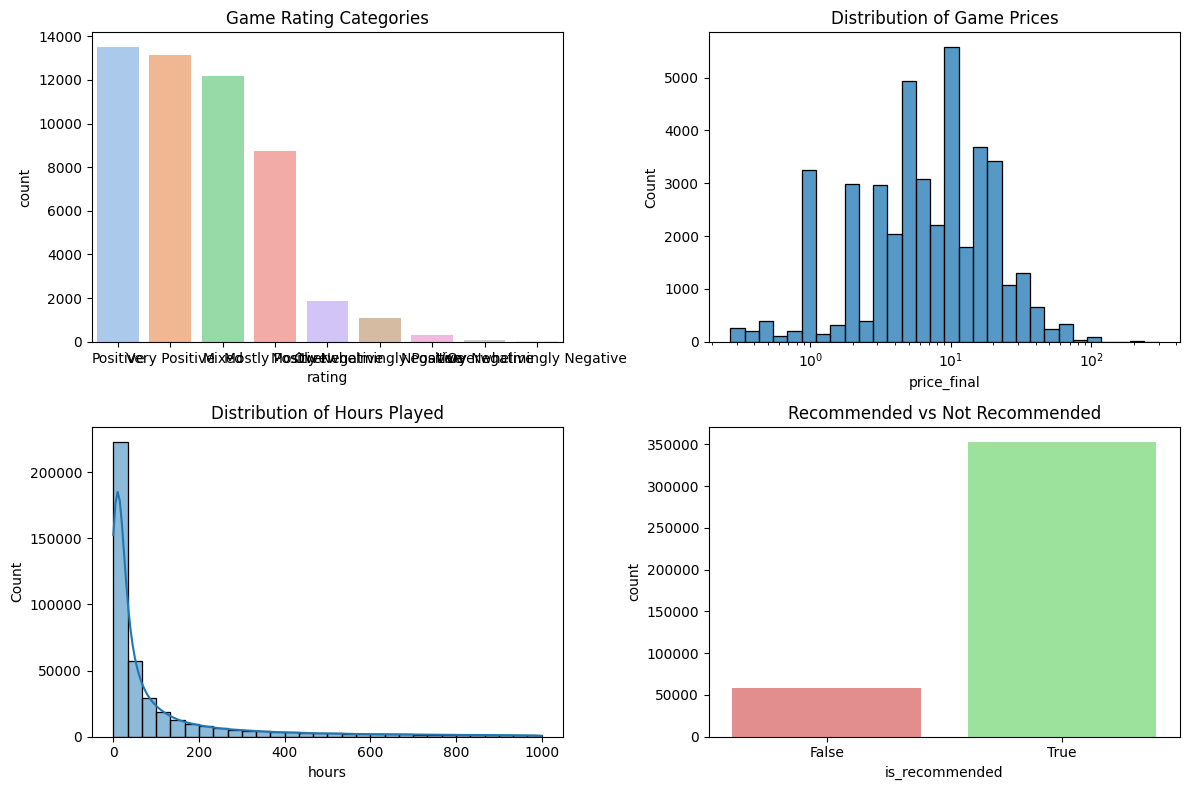

In [10]:
# Cell 5: EDA – Univariate Distributions (4 plots)
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
sns.countplot(x='rating', data=games, order=games['rating'].value_counts().index, palette='pastel')
plt.title('Game Rating Categories')

plt.subplot(2,2,2)
sns.histplot(games['price_final'], bins=30, log_scale=True)
plt.title('Distribution of Game Prices')

plt.subplot(2,2,3)
sns.histplot(df['hours'], bins=30, kde=True)
plt.title('Distribution of Hours Played')

plt.subplot(2,2,4)
sns.countplot(x='is_recommended', data=df, palette=['lightcoral','lightgreen'])
plt.title('Recommended vs Not Recommended')

plt.tight_layout()
plt.show()


<ipython-input-11-dfe0a8faa5ef>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rating', y='hours', data=df.sample(20000), palette='Set2')
<ipython-input-11-dfe0a8faa5ef>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='reviews_bin', y='hours', data=df, scale='width', palette='Set3')
<ipython-input-11-dfe0a8faa5ef>:17: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='reviews_bin', y='hours', data=df, scale='width', palette='Set3')


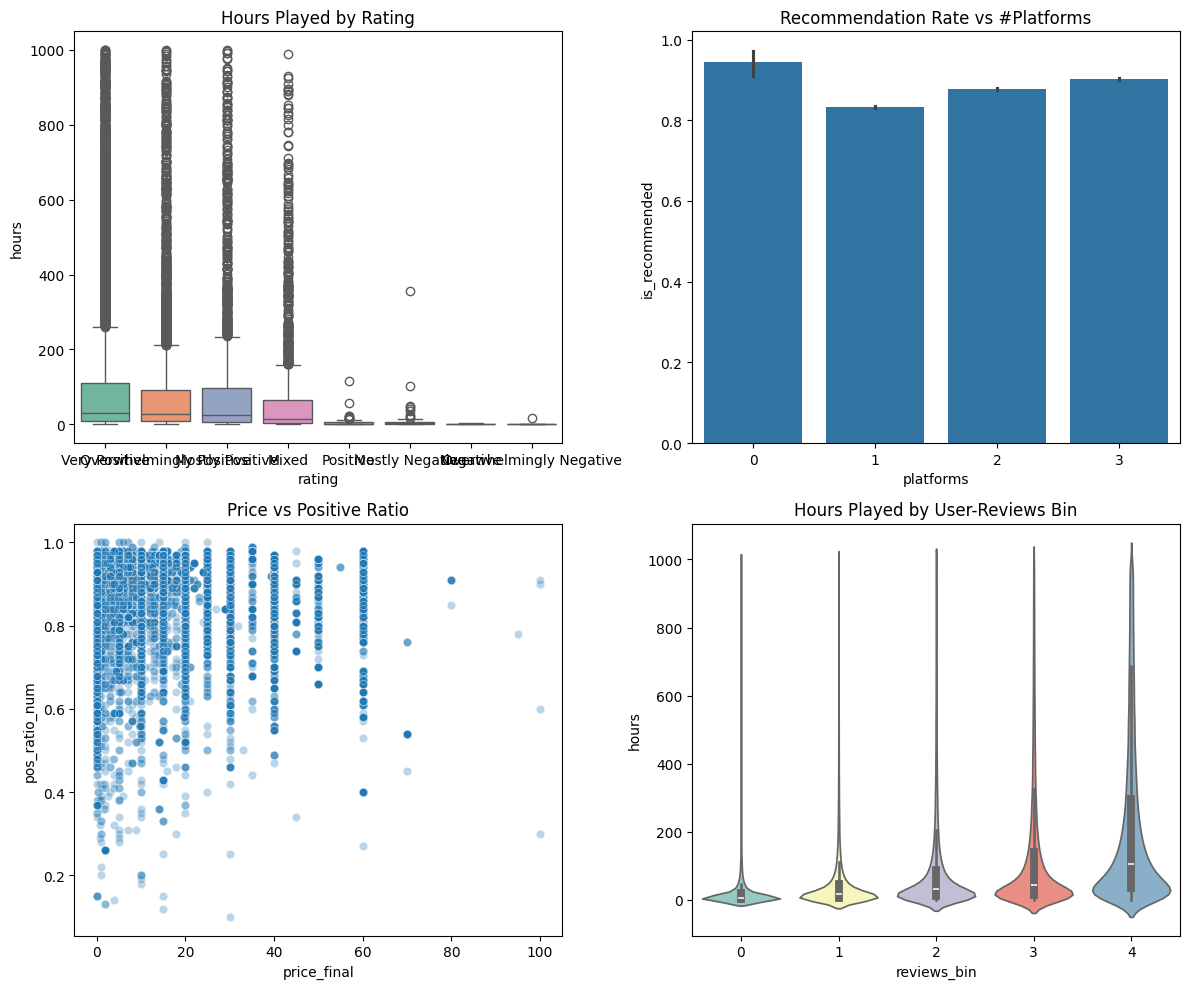

In [11]:
# Cell 6: EDA – Bivariate & Categorical (4 plots)
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
sns.boxplot(x='rating', y='hours', data=df.sample(20000), palette='Set2')
plt.title('Hours Played by Rating')

plt.subplot(2,2,2)
sns.barplot(x='platforms', y='is_recommended', data=df, estimator=np.mean)
plt.title('Recommendation Rate vs #Platforms')

plt.subplot(2,2,3)
sns.scatterplot(x='price_final', y='pos_ratio_num', data=df.sample(20000), alpha=0.3)
plt.title('Price vs Positive Ratio')

plt.subplot(2,2,4)
sns.violinplot(x='reviews_bin', y='hours', data=df, scale='width', palette='Set3')
plt.title('Hours Played by User-Reviews Bin')

plt.tight_layout()
plt.show()


<ipython-input-12-9a65e1684fac>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.set_index('date').groupby(pd.Grouper(freq='M'))['is_recommended'].mean()


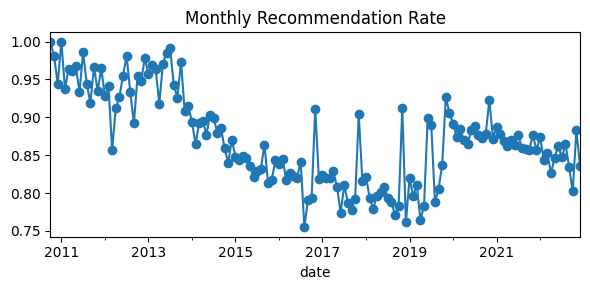

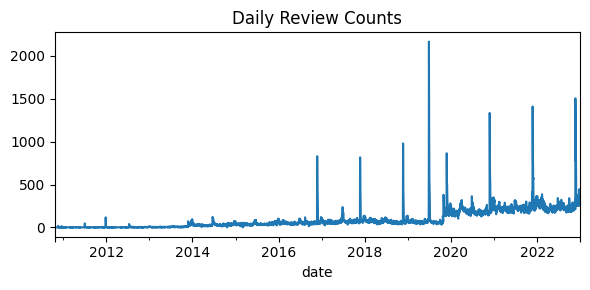

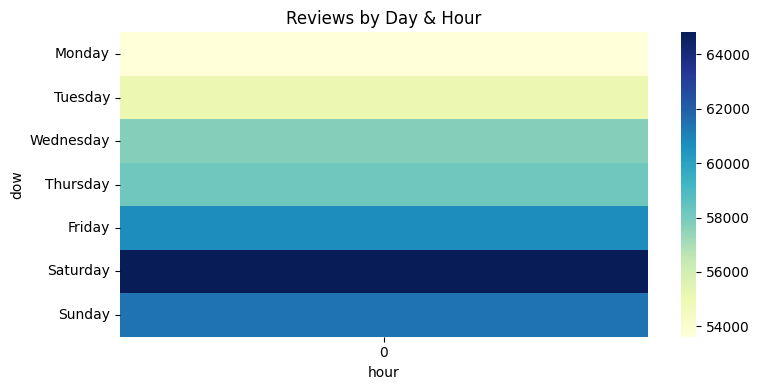

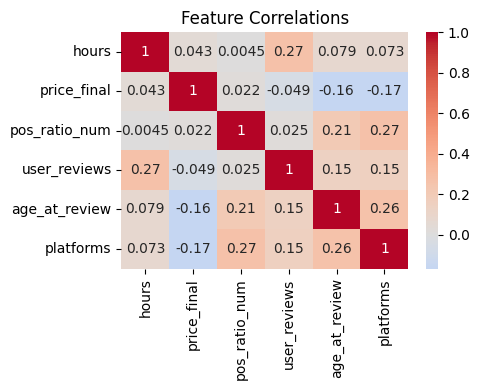

In [12]:
# Cell 7: EDA – Time Series & Heatmaps (4 plots)
# 1) Monthly rec rate
monthly = df.set_index('date').groupby(pd.Grouper(freq='M'))['is_recommended'].mean()
plt.figure(figsize=(6,3))
monthly.plot(marker='o')
plt.title('Monthly Recommendation Rate')
plt.tight_layout(); plt.show()

# 2) Daily counts
daily_counts = df.set_index('date').resample('D').size()
plt.figure(figsize=(6,3))
daily_counts.plot()
plt.title('Daily Review Counts')
plt.tight_layout(); plt.show()

# 3) Heatmap: day-of-week vs hour-of-day
df['dow'] = df['date'].dt.day_name()
df['hour'] = df['date'].dt.hour
pivot = df.pivot_table(index='dow', columns='hour', values='review_id', aggfunc='count').reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)
plt.figure(figsize=(8,4))
sns.heatmap(pivot, cmap='YlGnBu')
plt.title('Reviews by Day & Hour')
plt.tight_layout(); plt.show()

# 4) Correlation matrix
corr = df[['hours','price_final','pos_ratio_num','user_reviews','age_at_review','platforms']].corr()
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlations')
plt.tight_layout(); plt.show()


In [13]:
# Cell 8: Hypothesis Testing
# A) Hours played: recommended vs not
h_rec  = df.loc[df['is_recommended'], 'hours']
h_not  = df.loc[~df['is_recommended'], 'hours']
t1,p1 = stats.ttest_ind(h_rec, h_not, equal_var=False)
print("Hours t-test: t={:.2f}, p={:.4f}".format(t1,p1))

# B) Price: recommended vs not
pr_rec = df.loc[df['is_recommended'], 'price_final']
pr_not = df.loc[~df['is_recommended'], 'price_final']
t2,p2 = stats.ttest_ind(pr_rec, pr_not, equal_var=False)
print("Price t-test: t={:.2f}, p={:.4f}".format(t2,p2))

# C) ANOVA: hours across rating categories
groups = [df.loc[df['rating']==r, 'hours'] for r in df['rating'].unique() if len(df[df['rating']==r])>0]
f,p3 = stats.f_oneway(*groups)
print("ANOVA hours vs rating: F={:.2f}, p={:.4f}".format(f,p3))


Hours t-test: t=30.51, p=0.0000
Price t-test: t=3.11, p=0.0019
ANOVA hours vs rating: F=256.35, p=0.0000


              precision    recall  f1-score   support

       False       0.39      0.29      0.33     11705
        True       0.89      0.93      0.91     70605

    accuracy                           0.84     82310
   macro avg       0.64      0.61      0.62     82310
weighted avg       0.82      0.84      0.82     82310



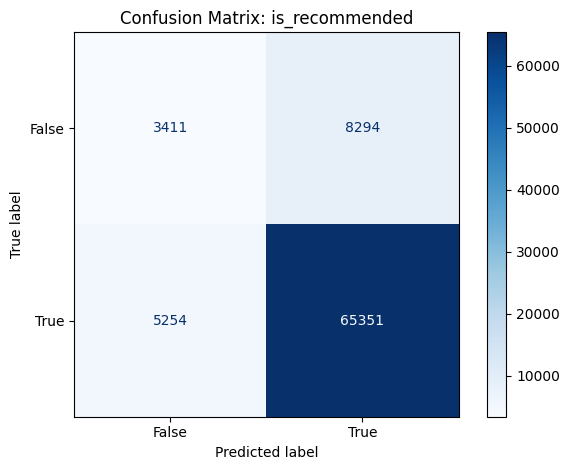

In [15]:
# Cell 10: Classification – Predict is_recommended
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import StandardScaler, OneHotEncoder
from sklearn.compose         import ColumnTransformer
from sklearn.pipeline        import Pipeline
from sklearn.ensemble        import RandomForestClassifier
from sklearn.metrics         import classification_report, ConfusionMatrixDisplay

# Features & target
X = df[['hours','price_final','pos_ratio_num','user_reviews','age_at_review','platforms']]
y = df['is_recommended']

X_tr, X_te, y_tr, y_te = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

pre = ColumnTransformer([
    ('num', StandardScaler(), ['hours','price_final','pos_ratio_num','user_reviews','age_at_review','platforms'])
])

pipe = Pipeline([
    ('prep', pre),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
])

pipe.fit(X_tr, y_tr)
y_pred = pipe.predict(X_te)
print(classification_report(y_te, y_pred))

ConfusionMatrixDisplay.from_estimator(pipe, X_te, y_te, cmap='Blues')
plt.title('Confusion Matrix: is_recommended')
plt.tight_layout(); plt.show()
